In [1]:
import numpy as np
import pandas as pd
import gc
import os
import sys
import yaml
import re
import random
import math
import matplotlib.pyplot as plt
import warnings
import pickle
from tqdm.notebook import tqdm
from typing import *
from pathlib import Path
from dataclasses import dataclass, field, asdict
from shutil import copyfile
from cuml.neighbors import NearestNeighbors
warnings.simplefilter('ignore')

In [22]:
@dataclass
class Config:
    outdir: str = "../results/bert-gkf"
    device: str = "cuda:2"
    device_id: int = 2

    modeldir: str = '../models/bert/bert_en_uncased_L-24_H-1024_A-16_1'
    seed: int = 123
    n_splits: int = 1
    
    # Training config
    batch_size: int = 32
    epochs: int = 100
    patience: int = 5
    lr: float = 0.00001
    max_len: int = 70
    emb_len: int = 2048

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [23]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [24]:
config = Config()
os.environ["CUDA_VISIBLE_DEVICES"] = str(config.device_id)

base_dir = Path().resolve()
sys.path.append(os.path.abspath(base_dir / '../'))

from src.tokenization import *
from src.preprocess import *
from src.text import *
from src.model import *

import tensorflow as tf
import tensorflow_hub as hub

In [32]:
train = pd.read_csv(base_dir / config.outdir / 'train_fold.csv')
n_classes = train.query('fold == 0').label_group.nunique()
train.head()

,posting_id,image,image_phash,title,label_group,matches,f1,fold
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,0,train_129225211 train_2278313361,0.666667,0
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",1,train_3386243561 train_3423213080,0.666667,0
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2,train_2288590299 train_3803689425,0.666667,1
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,3,train_2406599165 train_3342059966,0.666667,1
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,4,train_3369186413 train_921438619,0.666667,1


In [8]:
# Function to get our f1 score
def f1_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    len_y_true = y_true.apply(lambda x: len(x)).values
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1

In [16]:
def get_embeddings(bert_model, df: pd.DataFrame, x):
    chunk = 500
    iterator = np.arange(np.ceil(len(df) / chunk))

    embeds = []
    for j in tqdm(iterator):
        a = int(j * chunk)
        b = int((j + 1) * chunk)
        text_chunk = ((x[0][a:b], x[1][a:b], x[2][a:b]))
        embeddings = bert_model.predict(text_chunk, batch_size = config.batch_size)
        embeds.append(embeddings)

    embeddings = np.concatenate(embeds)
    return embeddings

In [18]:
def get_embeddings_list(max_len: int, epoch: int):
    epoch = format(epoch, '02')
    
    outdir = base_dir / config.outdir / f'Bert_seed{config.seed}_encodelen{max_len}_emb{config.emb_len}-gkf'
    weight_path = outdir / f"epoch{epoch}.h5"
    emb_outdir = outdir/ f'embeddings_epoch{epoch}.pkl'

    if os.path.exists(emb_outdir):
        embeddings = pickle.load(open(emb_outdir, 'rb'))
    else:
        bert_layer = hub.KerasLayer(str(base_dir / config.modeldir), trainable=True)
        vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
        do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
        tokenizer = FullTokenizer(vocab_file, do_lower_case)

        bert_model = build_bert_model(bert_layer, n_classes=n_classes, lr=config.lr, max_len=max_len, train=False, emb_len=config.emb_len)
        bert_model.load_weights(str(weight_path))
        bert_model = tf.keras.models.Model(inputs=bert_model.input[0:3], outputs=bert_model.layers[-4].output)

        x = bert_encode(train['title'].values, tokenizer, max_len=max_len)
        embeddings = get_embeddings(bert_model, train, x)


        pickle.dump(embeddings, open(emb_outdir, 'wb'))

        del bert_model
        gc.collect()
        tf.keras.backend.clear_session()

    return embeddings

In [45]:
def search_thresholds(df: pd.DataFrame, embeddings: np.ndarray, 
                      knn: int = 50, thr_start: int = 15, thr_end: int = 30, thr_interval: float = 1, verbose=False):
    # KNN
    knn_model = NearestNeighbors(n_neighbors=knn, metric='cosine')
    knn_model.fit(embeddings)
    
    valid_df = df.query('fold == 1')
    valid_embeddings = embeddings[valid_df.index, :]
    distances, indices = knn_model.kneighbors(valid_embeddings)
    
    # grid search
    thresholds = list(np.arange(thr_start, thr_end, thr_interval))
    scores = []
    for threshold in thresholds:
        predictions = []
        for k in range(valid_embeddings.shape[0]):
            idx = np.where(distances[k, ] < threshold)[0]
            ids = indices[k, idx]
            posting_ids = ' '.join(df['posting_id'].iloc[ids].values)
            predictions.append(posting_ids)
        valid_df['pred_matches'] = predictions
        valid_df['f1'] = f1_score(valid_df['matches'], valid_df['pred_matches'])
        score = valid_df['f1'].mean()
        if verbose:
            print(f'Our f1 score for threshold {np.round(threshold, 2)} is {score}')
        scores.append(score)
    thresholds_scores = pd.DataFrame({'thresholds': thresholds, 'scores': scores})
    
    max_score = thresholds_scores[thresholds_scores['scores'] == thresholds_scores['scores'].max()]
    best_threshold = max_score['thresholds'].values[0]
    best_score = max_score['scores'].values[0]
    print(f'Our best score is {best_score} and has a threshold {best_threshold}')
    
    return best_score, best_threshold


def database_augment(embeddings, n_aug):
    weights = np.logspace(0, -1.5, n_aug)
    model = NearestNeighbors(n_neighbors=n_aug, metric='cosine')
    model.fit(embeddings)
    distances, indices = model.kneighbors(embeddings)
    
    dba_embeddings = list()
    for k in range(embeddings.shape[0]):
        neighbor_embeddings = embeddings[indices[k, ]]
        comb = np.dot(weights, neighbor_embeddings)
        dba_embeddings.append(comb)
    dba_embeddings = np.vstack(dba_embeddings)
    
    del model, distances, indices
    gc.collect()
    return dba_embeddings

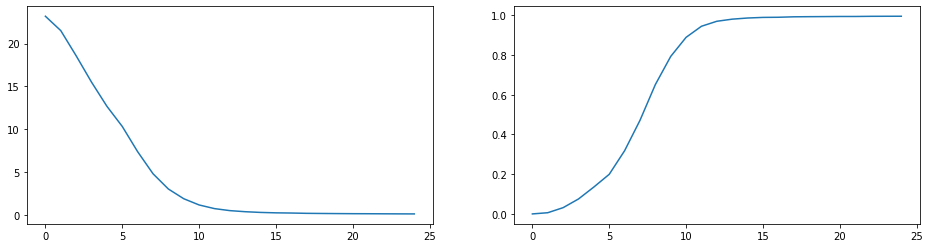

In [27]:
history = pickle.load(open(base_dir / config.outdir / f'Bert_seed{config.seed}_encodelen{config.max_len}_emb{config.emb_len}-gkf/history.pkl', 'rb'))

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(history['loss'])
axes[1].plot(history['sparse_categorical_accuracy'])
plt.show()

In [35]:
embeddings = get_embeddings_list(70, epoch=25)

In [37]:
search_thresholds(train, embeddings, 50, 0, 1, 0.1)

Our f1 score for threshold 0.0 is 0.21059822712690623
Our f1 score for threshold 0.1 is 0.5388107231449769
Our f1 score for threshold 0.2 is 0.5945894457413052
Our f1 score for threshold 0.3 is 0.6376099757245373
Our f1 score for threshold 0.4 is 0.650533192214583
Our f1 score for threshold 0.5 is 0.626587790151839
Our f1 score for threshold 0.6 is 0.5403282475131178
Our f1 score for threshold 0.7 is 0.37700766078354686
Our f1 score for threshold 0.8 is 0.18897849178485332
Our f1 score for threshold 0.9 is 0.170539546052095
Our best score is 0.650533192214583 and has a threshold 0.4


(0.650533192214583, 0.4)

In [38]:
embeddings = get_embeddings_list(70, epoch=15)

  0%|          | 0/69 [00:00<?, ?it/s]

In [39]:
search_thresholds(train, embeddings, 50, 0, 1, 0.1)

Our f1 score for threshold 0.0 is 0.2070045509887711
Our f1 score for threshold 0.1 is 0.5380560619191238
Our f1 score for threshold 0.2 is 0.5935914503999701
Our f1 score for threshold 0.3 is 0.6359068392091684
Our f1 score for threshold 0.4 is 0.6514626965421033
Our f1 score for threshold 0.5 is 0.6287464386616369
Our f1 score for threshold 0.6 is 0.5388350449450349
Our f1 score for threshold 0.7 is 0.37278546339870305
Our f1 score for threshold 0.8 is 0.18708064611647138
Our f1 score for threshold 0.9 is 0.1707360113853327
Our best score is 0.6514626965421033 and has a threshold 0.4


(0.6514626965421033, 0.4)

In [40]:
embeddings = get_embeddings_list(70, epoch=10)

  0%|          | 0/69 [00:00<?, ?it/s]

In [41]:
search_thresholds(train, embeddings, 50, 0, 1, 0.1)

Our f1 score for threshold 0.0 is 0.20442405898745372
Our f1 score for threshold 0.1 is 0.5415251447022117
Our f1 score for threshold 0.2 is 0.5967350327947998
Our f1 score for threshold 0.3 is 0.6377646314389882
Our f1 score for threshold 0.4 is 0.6508484042304131
Our f1 score for threshold 0.5 is 0.6185935858166668
Our f1 score for threshold 0.6 is 0.5185383179567334
Our f1 score for threshold 0.7 is 0.3462029577526888
Our f1 score for threshold 0.8 is 0.17853792664550805
Our f1 score for threshold 0.9 is 0.17016422224671046
Our best score is 0.6508484042304131 and has a threshold 0.4


(0.6508484042304131, 0.4)

In [46]:
embeddings = get_embeddings_list(70, epoch=15)

for n_aug in range(2, 8):
    print(n_aug)
    dba_embeddings = database_augment(embeddings, n_aug)
    search_thresholds(train, dba_embeddings, 50, 0.1, 0.4, 0.05)

2
Our best score is 0.657885541242587 and has a threshold 0.40000000000000013
3
Our best score is 0.677805619927886 and has a threshold 0.30000000000000004
4
Our best score is 0.6814057866464456 and has a threshold 0.25000000000000006
5
Our best score is 0.6798587229663523 and has a threshold 0.20000000000000004
6
Our best score is 0.6746974466449421 and has a threshold 0.15000000000000002
7
Our best score is 0.6664379821803854 and has a threshold 0.15000000000000002


In [47]:
dba_embeddings = database_augment(embeddings, 4)
search_thresholds(train, dba_embeddings, 50, 0.1, 0.3, 0.01)

Our best score is 0.6821620418953958 and has a threshold 0.23999999999999994


(0.6821620418953958, 0.23999999999999994)